In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

#data = pd.read_csv("flightData_0_deg.csv")
data = pd.read_csv("flightData_0_deg_2.csv")
data = data.iloc[::2].reset_index()
Alt = data["Altitude"]
Acc_Z = data["AccX"]
Time = data["Time"].div(1000)


In [74]:
def diff(X, T):
    V = []
    for i in range(1, len(X)):
        V.append((X[i]-X[i-1])/(T[i]-T[i-1]))
    return V

def integrate(X, T):
    V = [0]
    for i in range(1, len(X)):
        V.append(V[-1] + 0.5*(T[i]-T[i-1])*(X[i-1] + X[i]))
    return V

V_Baro = diff(Alt.tolist(), Time.tolist())
V_Acc = integrate(Acc_Z.tolist(), Time.tolist())


In [75]:
# Kalman Filter
def getF(delta_T):
    return np.array([[1, delta_T, 0.5*delta_T**2], [0, 1, delta_T], [0, 0, 1]])

def apogeePred(Alt_pred, Vel_pred, Acc_pred):
    G = 9.81
    v = Vel_pred
    a = Acc_pred-G
    p = Alt_pred
    return v*v*math.log(abs(a/G))/(2*abs(a+G)) + p


Alt_pred = []
Vel_pred = []
Acc_pred = []
pred_apogee_kalman = []
pred_apogee_baro = []
pred_apogee_acc = []

C = np.array([[1, 0, 0], [0, 0, 1]])
# State Vector
Xk = np.array([[0], [0], [0]])
# State Estimate Covariance
Pk = np.array([[0.01, 0, 0], [0, 0.01, 0], [0, 0, 0.01]])
#Pk = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
# Sensor Covariance
#R = np.array([[0.0929, 0], [0, 0.4609]])
#R = np.array([[0.001, 0], [0, 0.1]])
R = np.array([[0.0001, 0], [0, 0.01]])
# Model Covariance
#Q = np.array([[0.000001, 0, 0], [0, 0, 0], [0, 0, 0.1]])
Q = np.array([[0.000001, 0, 0], [0, 0.00001, 0], [0, 0, 0.1]])

for i in range(1, len(Time)-1):
    delta_T = Time[i] - Time[i-1]
    Y = np.array([[Alt[i]], [Acc_Z[i]]])
    F = getF(delta_T)
    Xkp_min = F.dot(Xk)
    Ykp_min = C.dot(Xkp_min)
    Pkp_min = F.dot(Pk).dot(np.transpose(F)) + Q
    K = Pkp_min.dot(np.transpose(C)).dot(np.linalg.inv(C.dot(Pkp_min).dot(np.transpose(C)) + R))
    Xk = Xkp_min + K.dot(Y - Ykp_min)
    Pk = (np.eye(3) - K.dot(C)).dot(Pkp_min)
    
    #print(str(Xk[0][0])+','+str(Xk[1][0])+','+str(Xk[2][0]))
    
    Alt_pred.append(Xk[0][0])
    Vel_pred.append(Xk[1][0])
    Acc_pred.append(Xk[2][0])

    #print("" + str(Xk[0][0]) + "," + str(Xk[1][0])+ "," + str(Xk[2][0]))
  
    pred_apogee_kalman.append(apogeePred(Alt_pred[-1], Vel_pred[-1], Acc_pred[-1]))
    pred_apogee_baro.append(apogeePred(Alt[i], V_Baro[i], Acc_Z[i]))
    pred_apogee_acc.append(apogeePred(Alt[i], V_Acc[i], Acc_Z[i]))


/var/folders/lf/y2dbt1p952xcbzcjt7hlkcm00000gn/T/ipykernel_36005/1629965469.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return v*v*math.log(abs(a/G))/(2*abs(a+G)) + p


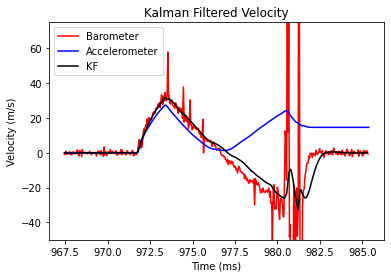

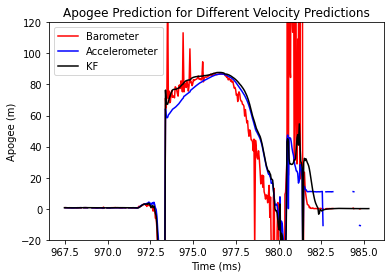

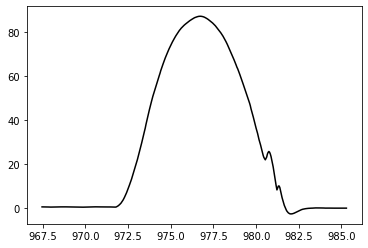

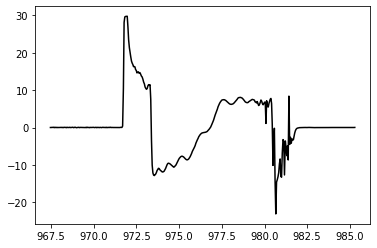

In [76]:
#plt.plot(Time, Alt)
#plt.show()
import math
plt.plot(Time[:-1], V_Baro, 'r')
plt.plot(Time, V_Acc, 'b')
plt.plot(Time[:-2], Vel_pred, 'k')
plt.title("Kalman Filtered Velocity")
plt.xlabel("Time (ms)")
plt.ylabel("Velocity (m/s)")
plt.legend(['Barometer', 'Accelerometer', 'KF'])
plt.ylim([-50, 75])
plt.show()

# Predictions using different velocity prediction methods
plt.plot(Time[:-2], pred_apogee_baro, 'r')
plt.plot(Time[:-2], pred_apogee_acc, 'b')
plt.plot(Time[:-2], pred_apogee_kalman, 'k')
plt.title("Apogee Prediction for Different Velocity Predictions")
plt.xlabel("Time (ms)")
plt.ylabel("Apogee (m)")
plt.legend(['Barometer', 'Accelerometer', 'KF'])
plt.ylim([-20, 120])
plt.show()

plt.plot(Time[:-2], Alt_pred, 'k')
plt.show()
plt.plot(Time[:-2], Acc_pred, 'k')
plt.show()
